# Audio as a waveform
You may have seen sounds visualized as a waveform, which plots the sample values over time and illustrates the changes in the sound’s amplitude. This is also known as the time domain representation of sound.

This type of visualization is useful for identifying specific features of the audio signal such as the timing of individual sound events, the overall loudness of the signal, and any irregularities or noise present in the audio.

To plot the waveform for an audio signal, we can use a Python library called librosa. Let’s take an example sound called “trumpet” that comes with the library:

In [24]:
import librosa  # For manipulating audio
import numpy as np
from IPython.display import Audio  # For displaying audio

array, sampling_rate = librosa.load(librosa.ex("trumpet"))

Audio(filename=librosa.ex("trumpet"))

The example is loaded as a tuple of audio time series (here we call it "array"), and sampling rate (sampling_rate).

What's cool is that since our sampled audio is stored as a sequence of numbers, we can simply use matplotlib to plot it. Huggingface uses waveshow which produces a better output, but it's cool to be able to plot the wave on your own.

First 20 samples of audio:
[-1.4068246e-03 -4.4607770e-04 -4.1098156e-04  9.9922603e-05
  4.3147978e-05 -1.7485370e-04 -3.6783644e-04  1.4553108e-04
  5.0557696e-04  1.4929977e-03  1.8555233e-03  9.2913560e-04
 -4.0743421e-04 -2.0390274e-03 -1.2686799e-03 -5.3472869e-04
  8.9941692e-04  9.7593718e-04  1.0020013e-03 -1.2960774e-03]


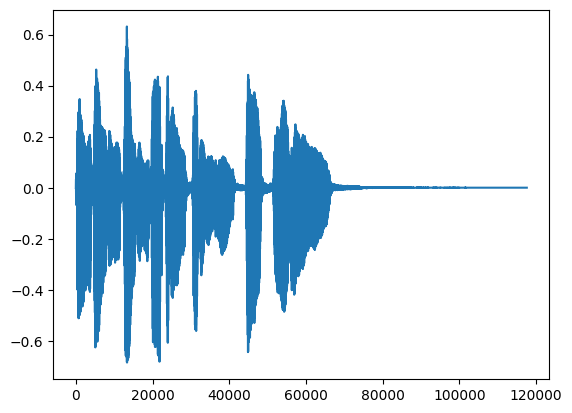

In [25]:
import matplotlib.pyplot as plt

print("First 20 samples of audio:")
print(array[0:20])
print()
plt.plot(array)

Currently, the x-axis is in terms of samples. Let's fix that and a few other things:

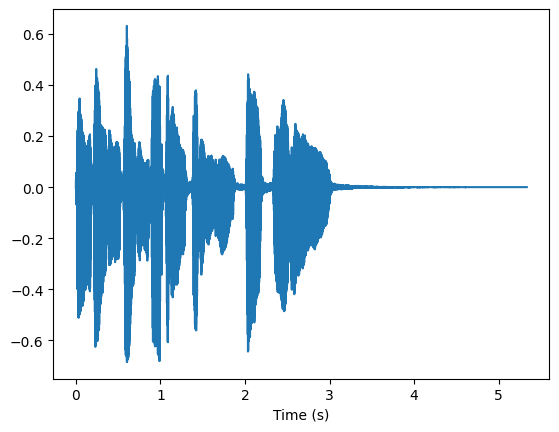

In [26]:
time = np.linspace(0, len(array)/sampling_rate, num=len(array))  # Creates a list of linearly increasing numbers, with the nth entry containing the time of the nth sample in seconds
plt.plot(time, array)  # Plot the time array on the x-axis and the sound array on the y-axis
plt.xlabel("Time (s)")
plt.show()

Now the output should be more or less identical to Huggingface. It's super critical that audio can be represented as a temporal sequence of numbers; this is what allows deep learning to do all its magic.

# The frequency spectrum
Another way to visualize audio data is to plot the frequency spectrum of an audio signal, also known as the frequency domain representation. The spectrum is computed using the discrete Fourier transform or DFT. It describes the individual frequencies that make up the signal and how strong they are.

Let’s plot the frequency spectrum for the same trumpet sound by taking the DFT using numpy’s rfft() function. While it is possible to plot the spectrum of the entire sound, it’s more useful to look at a small region instead. Here we’ll take the DFT over the first 4096 samples, which is roughly the length of the first note being played.

The below plot contains the strength of the various frequency components that are present in this audio segment. The frequency values are on the x-axis, usually plotted on a logarithmic scale, while their amplitudes are on the y-axis.

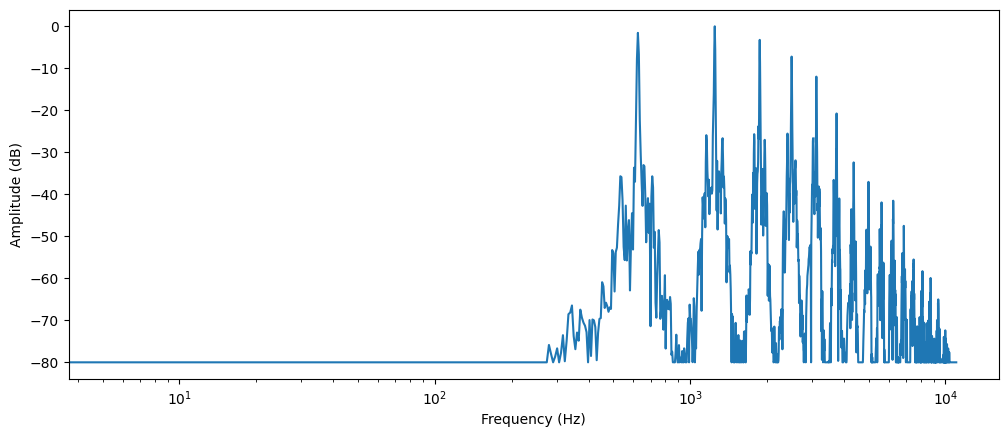

In [27]:
dft_input = array[:4096]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

Let's see what happens when we zoom in on the peaks:


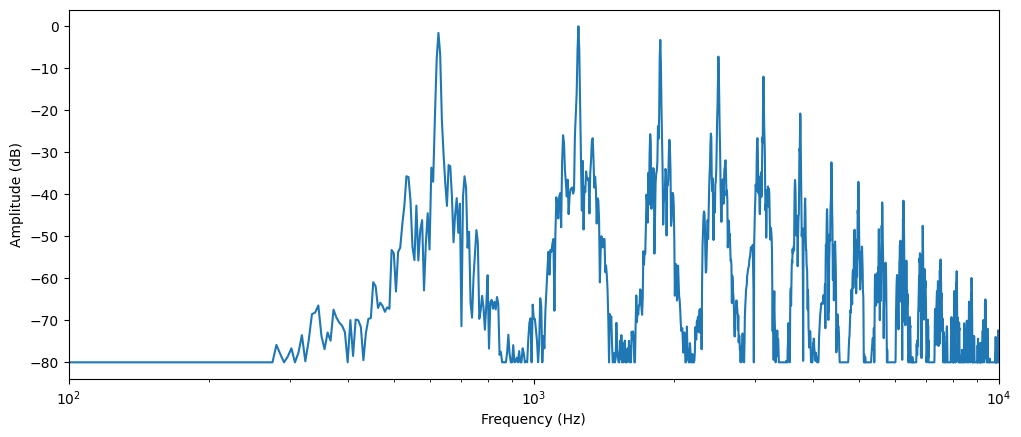

In [28]:
plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlim(10**2,10**4)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

The frequency spectrum that we plotted shows several peaks. We can tell what note the human perceives the sound as by looking for the lowest-frequency peak in the graph (called the fundamental frequency) and converting that frequency to note names. Since the fundamental frequency is ~620 Hz, this trumpet is playing Eb5.

But wait! If a trumpet and a clarinet play the same Eb5 note, they obviously don't sound the same! How do the graphs differ? The answer is in the "harmonics" on the graph (the other non-fundamental peaks). The amount of these harmonics dictates what the final sound resembles. Each of these harmonics is usually (but not always) an integer multiple of the fundamental frequency.

Look here for more information on the physics of a trumpet (optional): https://www.nickdrozdoff.com/post/2018/10/15/standing-wave-in-trumpet-wind-column

The output of the DFT is an array of complex numbers, made up of real and imaginary components. Taking the magnitude with np.abs(dft) extracts the amplitude information from the spectrogram. The angle between the real and imaginary components provides the so-called phase spectrum, but this is often discarded in machine learning applications.

You used librosa.amplitude_to_db() to convert the amplitude values to the decibel scale, making it easier to see the finer details in the spectrum. Sometimes people use the power spectrum, which measures energy rather than amplitude; this is simply a spectrum with the amplitude values squared.

# Spectrogram
What if we want to see how the frequencies in an audio signal change? The trumpet plays several notes and they all have different frequencies. The problem is that the spectrum only shows a frozen snapshot of the frequencies at a given instant. The solution is to take multiple DFTs, each covering only a small slice of time, and stack the resulting spectra together into a spectrogram.

A spectrogram plots the frequency content of an audio signal as it changes over time. It allows you to see time, frequency, and amplitude all on one graph. The algorithm that performs this computation is the STFT or Short Time Fourier Transform.

The spectrogram is one of the most informative audio tools available to you. For example, when working with a music recording, you can see the various instruments and vocal tracks and how they contribute to the overall sound. In speech, you can identify different vowel sounds as each vowel is characterized by particular frequencies.

Let’s plot a spectrogram for the same trumpet sound, using librosa’s stft() and specshow() functions:

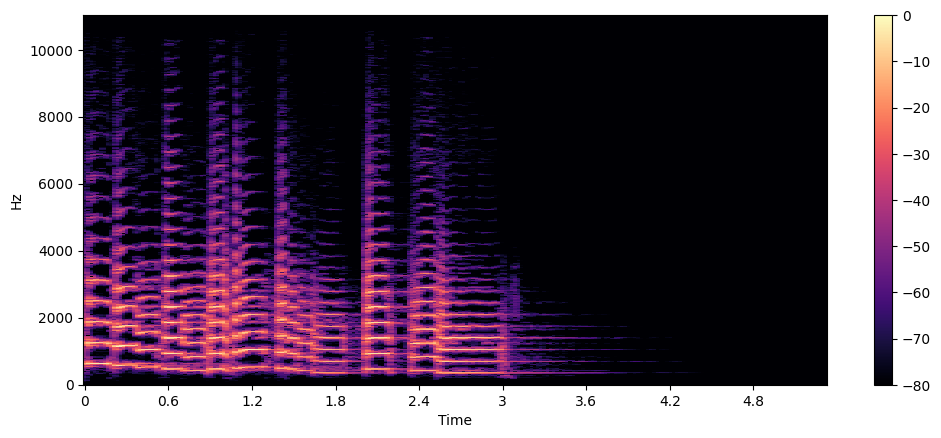

In [29]:
D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

In this plot, the x-axis represents time as in the waveform visualization but now the y-axis represents frequency in Hz. The intensity of the color gives the amplitude or power of the frequency component at each point in time, measured in decibels (dB).

The spectrogram is created by taking short segments of the audio signal, typically lasting a few milliseconds, and calculating the discrete Fourier transform of each segment to obtain its frequency spectrum. The resulting spectra are then stacked together on the time axis to create the spectrogram. Each vertical slice in this image corresponds to a single frequency spectrum, seen from the top. By default, librosa.stft() splits the audio signal into segments of 2048 samples, which gives a good trade-off between frequency resolution and time resolution.

Since the spectrogram and the waveform are different views of the same data, it’s possible to turn the spectrogram back into the original waveform using the inverse STFT. However, this requires the phase information in addition to the amplitude information. If the spectrogram was generated by a machine learning model, it typically only outputs the amplitudes. In that case, we can use a phase reconstruction algorithm such as the classic Griffin-Lim algorithm, or using a neural network called a vocoder, to reconstruct a waveform from the spectrogram.

Spectrograms aren’t just used for visualization. Because spectrograms are images, many machine learning models take spectrograms as input and apply techniques that would normally be suited to normal image classification/prediction/generation. This is super powerful because it means machine learning engineers can reuse techniques between audio and video.

# Mel spectrogram
A mel spectrogram is a variation of the spectrogram that is commonly used in speech processing and machine learning tasks to provide a more "humanistic" view of a sound. The human auditory system is more sensitive to changes in lower frequencies than higher frequencies, and this sensitivity decreases logarithmically as frequency increases. The mel scale is a perceptual scale that approximates the non-linear frequency response of the human ear.

To create a mel spectrogram, the STFT is used just like before, splitting the audio into short segments to obtain a sequence of frequency spectra. Additionally, each spectrum is sent through a set of filters, the so-called mel filterbank, to transform the frequencies to the mel scale.

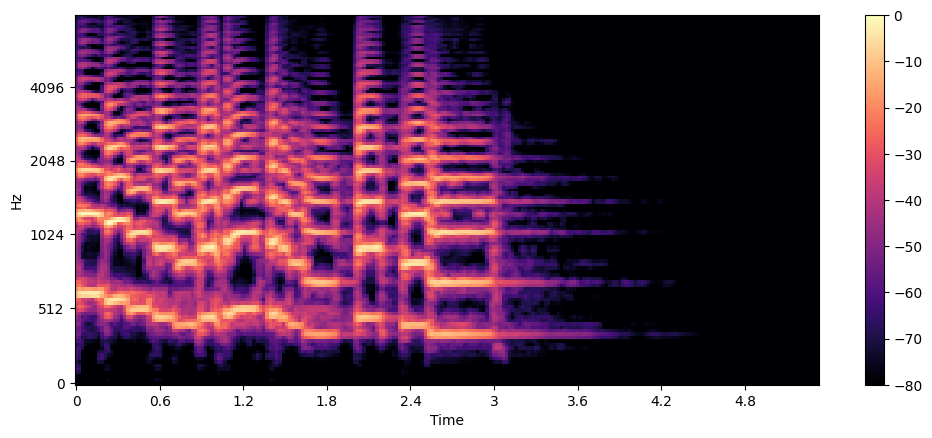

In [30]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

In the example above, n_mels stands for the number of mel bands to generate. The mel bands define a set of frequency ranges that divide the spectrum into perceptually meaningful components, using a set of filters whose shape and mspacing are chosen to mimic the way the human ear responds to different frequencies. Common values for n_mels are 40 or 80. fmax indicates the highest frequency (in Hz) we care about.

Just as with a regular spectrogram, it’s common practice to express the strength of the mel frequency components in decibels. This is commonly referred to as a log-mel spectrogram, because the conversion to decibels involves a logarithmic operation. The above example used librosa.power_to_db() as librosa.feature.melspectrogram() creates a power spectrogram.

Creating a mel spectrogram is a lossy operation as it involves filtering the signal. Converting a mel spectrogram back into a waveform is more difficult than doing this for a regular spectrogram, as it requires estimating the frequencies that were thrown away. This is why machine learning models such as HiFiGAN vocoder are needed to produce a waveform from a mel spectrogram.

Compared to a standard spectrogram, a mel spectrogram can capture more meaningful features of the audio signal for human perception, making it a popular choice in tasks such as speech recognition, speaker identification, and music genre classification.